***
# Exercise: _Optimization_
***

We will implement various optimization algorithms and examine their performance for various tasks.


1. First-order, smooth optimization using gradient descent 
    - Implement basic gradient descent solver
    - Implement gradient descent with armijo backtracking
2. Smooth One-class SVM
    - Implement hinge- and Huber loss functions
    - Implement objective and derivative of the smooth one-class svm
    - Use check_grad to verify the implementation
3. First-order, non-smooth optimization using sub-gradient descent
    - Implement objective and derivative of $\ell_p$-norm regularized one-class svm
4. Utilizing Available QP Solver Packages: CVXOPT
    - Use cvxopt qp solver to solve the primal one-class svm optimization problem
5. Utilizing Available Solver Packages: SciPy's Optimization Suite
    - Apply scipy's _minimize_ function on your implementation of the objective function of the smooth one-class svm 


In [85]:
from functools import partial
from scipy.optimize import check_grad, minimize

import numpy as np
import cvxopt as cvx

import matplotlib.pyplot as plt
%matplotlib inline

### 1. First-order, smooth optimization using gradient descent 

In this first part, we want use various variants of gradient descent for continuous and 
smooth optimization.

A well-known continuous, convex, smooth method is l2-norm regularized logistic regression.
Which has the following objective function:

$f(w) = \frac{\lambda}{2} \|w\|^2 + \sum_{i=1}^n \log(1+\exp(-y_i\langle w, x_i \rangle))$

In order to apply gradient descent, we will further need the first derivative:

$f'(w) = \lambda w + \sum_{i=1}^n \frac{-y_i}{1+\exp(y_i(\langle w, x_i \rangle))}x_i$.

In [86]:
def fun_l2_logistic_regression(w, X, y, param):
    w = w.reshape(w.size, 1)
    t1 = 1. + np.exp(-y * w.T.dot(X).T)
    f = param/2.*w.T.dot(w) + np.sum(np.log(t1))
    return f[0,0]

def grad_l2_logistic_regression(w, X, y, param):
    w = w.reshape(w.size, 1)
    t2 = 1. + np.exp(y * w.T.dot(X).T)
    grad = param*w + (-y/t2).T.dot(X.T).T
    return grad.ravel()

In [87]:
def findMin0(fun, grad, w, alpha, max_evals=10, eps=1e-2, verbosity=1):
    f = fun(w)
    g = grad(w)
    evals = 1
    while evals < max_evals:
        w = w - alpha * g
        f = fun(w)
        g = grad(w)
        evals += 1
        opt_cond = np.linalg.norm(g, ord=np.inf)
        if verbosity > 0:
            print('{0} {1:5.5f} {2:5.5f} {3:5.5f}'.format(evals, alpha, f, opt_cond))
        if opt_cond < eps:
            break
    print('{0} {1:5.5f} {2:5.5f} {3:5.5f}'.format(evals, alpha, f, opt_cond))
    return w

Ok, let us generate some small data set to try out our optimization schemes.

In [88]:
# Generate some test data
np.random.seed(42)
X = np.random.randn(10, 100)
w = np.random.randn(10, 1)
reg_y = w.T.dot(X)
median = np.median(reg_y)
y = -np.ones((reg_y.size, 1), dtype=np.int)
y[reg_y.ravel() >= median] = +1

We have a look at the most basic gradient descent method we can think of and 
start playing with the step-size $\alpha$. Try some, e.g.
- $\alpha=1.0$ 
- $\alpha=1e-6$
- $\alpha=0.001$

What do you notice?

In [104]:
fun = partial(fun_l2_logistic_regression, X=X, y=y, param=1.)
grad = partial(grad_l2_logistic_regression, X=X, y=y, param=1.)

print(check_grad(fun, grad, 0.0*np.random.randn(10)))

wstar = findMin0(fun, grad, 0.0*np.random.randn(10), 0.001, max_evals=1000, eps=1e-8, verbosity=0)

2.334026460825949e-06
1000 0.00100 23.10870 0.21163


We do not want to tweak the $\alpha$'s for every single optimization problem. This is where
line search steps in. 

In [90]:
def findMinBT(fun, grad, w, alpha, gamma, max_evals=10, eps=1e-2, verbosity=1):
    f = fun(w)
    g = grad(w)
    evals = 1
    while evals < max_evals:
        while fun(w - alpha * g) > f - gamma*alpha*g.dot(g):
            alpha /= 2.
        w = w - alpha * g
        f = fun(w)
        g = grad(w)            
        evals += 1
        opt_cond = np.linalg.norm(g, ord=np.inf)
        if verbosity > 0:
            print('{0} {1:5.5f} {2:5.5f} {3:5.5f}'.format(evals, alpha, f, opt_cond))
        if opt_cond < eps:
            break
    print('{0} {1:5.5f} {2:5.5f} {3:5.5f}'.format(evals, alpha, f, opt_cond))
    return w

In [106]:
fun = partial(fun_l2_logistic_regression, X=X, y=y, param=1.)
grad = partial(grad_l2_logistic_regression, X=X, y=y, param=1.)

print(check_grad(fun, grad, 0.0*np.random.randn(10)))
wstar = findMinBT(fun, grad, 0.0*np.random.randn(10), 1., 0.001, max_evals=100, verbosity=0)

2.334026460825949e-06
28 0.06250 23.08338 0.00862


More elaborate optimization methods (e.g. Newton descent) will use second-order information in order to find a better step-length. We will come back to this later.

### 2. Smooth One-class SVM

Since this is an anomaly detection workshop, we want to train some anomaly detectors.
So, here is our one-class SVM primal problem again:

$\min_{w,\rho,\xi} \frac{1}{2}\|w\|^2 - \rho + \frac{1}{n\nu} \sum_{i=1}^n \xi_i$

subject to the following constraints:

$\xi_i \geq 0\;, \quad \langle w, x_i \rangle \geq \rho - \xi_i \; , \quad \forall \; i$

This OP is unfortunately neither smooth nor unconstrained. So, lets change this.
1. We will get rid of the constraints by re-formulating them 
$\xi_i \geq 0\;, \quad \langle w, x_i \rangle \geq \rho - \xi_i \; \Rightarrow 
\xi_i \geq 0\;, \quad \xi_i \geq \rho - \langle w, x_i \rangle$
Since we minimize the objective, the RHS will hold with equality. Hence we can
replace $\xi_i$ in the objective with the RHS. However, we need to take care also of the
LHS which states that if LHS is smaller than $0$ the value should stay $0$. This can be achieved
by taking a $max(0, RHS)$. Hence, we land at the following _unconstrained_ problem:

    $\min_{w,\rho} \frac{1}{2}\|w\|^2 - \rho + \frac{1}{n\nu} \sum_{i=1}^n max(0,\rho - \langle w, x_i \rangle)$,

    which can be written in terms of a general loss function $\ell$ as

    $\min_{w,\rho} \frac{1}{2}\|w\|^2 - \rho + \frac{1}{n\nu} \sum_{i=1}^n \ell(\rho - \langle w, x_i \rangle)$.


    This is now unconstrained but still not smooth as the max (which is BTW called the hinge-loss) introduces some non-smoothness into the problem and gradient descent solvers can not readily applied. So, lets make it differentiable by approximation.
    
    
2. Approximating the hinge-loss by differentiable Huber-loss

    $\ell_{\Delta,\epsilon}(x) := 
        \left\{\begin{array}{lr}
         x -\Delta, & \text{for } x \geq \Delta + \epsilon\\
        \frac{(\epsilon + x - \Delta)^2}{4\epsilon}, & \text{for } \Delta - \epsilon\leq x\leq \Delta + \epsilon\\
        0, & \text{else}
        \end{array}\right\}$
        
    ..and the corresponding derivative is (I hope):
   
    $\frac{\partial}{\partial x}\ell_{\Delta,\epsilon}(x) := 
        \left\{\begin{array}{lr}
        1, & \text{for } x \geq \Delta + \epsilon\\
        \frac{(\epsilon + x - \Delta)}{2\epsilon}, & \text{for } \Delta - \epsilon\leq x\leq \Delta + \epsilon\\
        0, & \text{else}
        \end{array}\right\}$
    
    For our purposes, $\Delta=0.0$ and $\epsilon=0.5$ will suffice.


(1) Implement the hinge loss $\ell(x) = \max(0,x)$

(2) Implement the Huber loss as defined above

In [92]:
def hinge_loss(x):
    l_x = np.zeros(x.size)
    inds = np.argwhere(x > 0).ravel()
    l_x[inds] = x[inds]
    return l_x

def huber_loss(x, delta, epsilon):
    l_x = np.zeros(x.size)
    
    inds = np.argwhere(x >= delta + epsilon).ravel()
    l_x[inds] = x[inds] - delta
    
    inds = np.argwhere(np.logical_and((delta - epsilon <= x), (x <= delta + epsilon))).ravel()
    l_x[inds] = (epsilon+x[inds]-delta)*(epsilon+x[inds]-delta) / (4.*epsilon)
    return l_x

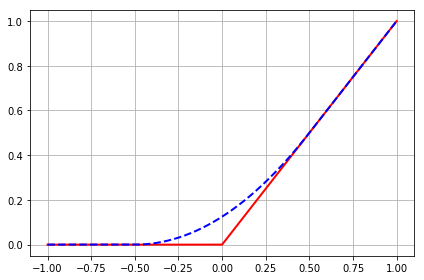

In [93]:
xs = np.linspace(-1, +1, 1000)

plt.plot(xs, hinge_loss(xs), '-r', linewidth=2.0)
plt.plot(xs, huber_loss(xs, 0.0, 0.5), '--b', linewidth=2.0)

plt.grid()
plt.tight_layout()

In [94]:
def fun_smooth_ocsvm(var, X, nu, delta, epsilon):
    rho = var[0]
    w = var[1:]
    w = w.reshape(w.size, 1)
    
    n = X.shape[1]
    d = X.shape[0]
    
    inner = (rho - w.T.dot(X)).ravel()
    loss = np.zeros(n)
    
    inds = np.argwhere(inner >= delta + epsilon)
    loss[inds] = inner[inds] - delta

    inds = np.argwhere(np.logical_and((delta - epsilon <= inner), (inner <= delta + epsilon))).ravel()
    loss[inds] = (epsilon + inner[inds]- delta)*(epsilon + inner[inds] -delta) / (4.*epsilon)
    
    f = 1./2.*w.T.dot(w) - rho + np.sum(loss) / (n*nu)
    return f[0,0]

def grad_smooth_ocsvm(var, X, nu, delta, epsilon):
    rho = var[0]
    w = var[1:]
    w = w.reshape(w.size, 1)
    
    n = X.shape[1]
    d = X.shape[0]
    
    inner = (rho - w.T.dot(X)).ravel()
    grad_loss_rho = np.zeros(n)
    grad_loss_w = np.zeros((n,d))
    
    inds = np.argwhere(inner >= delta + epsilon).ravel()
    grad_loss_rho[inds] = 1.
    grad_loss_w[inds, :] = -X[:, inds].T

    inds = np.argwhere(np.logical_and((delta - epsilon <= inner), (inner <= delta + epsilon))).ravel()
    grad_loss_rho[inds] = (-delta + epsilon + inner[inds]) / (2.*epsilon) 
    grad_loss_w[inds, :] = ((-delta + epsilon + inner[inds]) / (2.*epsilon) * (-X[:, inds])).T
    
    grad = np.zeros(d+1)
    grad[0] = -1 + np.sum(grad_loss_rho) / (n*nu)
    grad[1:] = w.ravel() + np.sum(grad_loss_w, axis=0) / (n*nu)
    return grad.ravel()

In [95]:
# Generate some test data
np.random.seed(42)
X = np.random.randn(10, 100)

In [109]:
fun = partial(fun_smooth_ocsvm, X=X, nu=1.0, delta=0., epsilon=0.5)
grad = partial(grad_smooth_ocsvm, X=X, nu=1.0, delta=0., epsilon=0.5)

# First, check gradient vs numerical gradient.
# This should give very small results.
print(check_grad(fun, grad, np.random.randn(10+1)))

xstar = findMinBT(fun, grad, 0.0*np.random.randn(10+1), 1., 0.0001, max_evals=1000, eps=1e-4, verbosity=0)
wstar = xstar[1:]

print(wstar)
print(np.mean(X, axis=1))
print(np.linalg.norm(wstar - np.mean(X, axis=1)))

2.0391285241858912e-07
362 1.00000 -0.04851 0.00010
[-0.10373093  0.02240406  0.0648898   0.10672381 -0.05590757 -0.11514215
  0.02419325 -0.00616242  0.22849043  0.02790996]
[-0.10384652  0.02230459  0.06489625  0.10684012 -0.05600447 -0.1153056
  0.02409386 -0.00616057  0.22864907  0.02785382]
0.00033336020184623736


### 3. First-order, non-smooth optimization using sub-gradient descent 

Unfortunately, many interesting methods do contain a non-smooth part in their objective. Examples 
include support vector machines (SVMs), one-class support vector machines (OCSVM), and support vector data descriptions.

Here, we gonna implement a version of the primal one-class SVM with a $\ell_p$-norm 
regularizer. This will allow us to control the sparsity of the found solution vector:

$\min_{w,\rho} \|w\|_p - \rho + \frac{1}{n\nu} \sum_{i=1}^n max(0,\rho - \langle w, x_i \rangle)$,

The resulting optimization problem is unconstrained but non-smooth. We will use a subgradient descent solver 
for this problem.


In [26]:
def findMinSG(fun, grad, x0, rate, max_evals=1000, eps=1e-2, step_method=1, verbosity=1):
    dims = x0.size
    x = x0
    best_x = x
    best_obj = np.float64(1e20)
    obj_bak = -1e10
    evals = 0
    is_converged = False
    while not is_converged and evals < max_evals:
        obj = fun(x)
        # this is subgradient, hence need to store the best solution so far
        if best_obj >= obj:
            best_x = x
            best_obj = obj

        # stop, if progress is too slow
        if np.abs((obj-obj_bak)) < eps:
            is_converged = True
            continue
        obj_bak = obj
        
        # gradient step for threshold
        g = grad(x)
        if step_method == 1:
            # constant step
            alpha = rate
        elif step_method == 2:
            # non-summable dimishing step size
            alpha = rate / np.sqrt(np.float(evals+1.)) / np.linalg.norm(g)
        else:
            # const. step length
            alpha = rate / np.linalg.norm(g)
            
        if verbosity > 0:
            print('{0} {1:5.5f} {2:5.5f} {3:5.5f}'.format(evals, alpha, obj, np.abs((obj-obj_bak))))           

        # update
        x = x - alpha*g
        evals += 1

    print('{0} {1:5.5f} {2:5.5f} {3:5.5f}'.format(evals, alpha, obj, np.abs((obj-obj_bak))))           
    return best_x

In [110]:
def fun_lp_norm(w, p=2.):
    pnorm = np.sum(np.abs(w)**p)**(1./p)    
    return pnorm

def grad_lp_norm(w, p=2.):
    pnorm1 = np.sum(np.abs(w)**p)**((p-1.)/p)
    grad_pnorm = (w*np.abs(w)**(p-2.)) / pnorm1
    return grad_pnorm.ravel()

fun = partial(fun_lp_norm, p=1.2)
grad = partial(grad_lp_norm, p=1.2)
print(check_grad(fun, grad, np.random.randn(100)))

2.4215589009424396e-06


In [63]:
def fun_lp_norm_ocsvm(var, X, p, nu):
    feat, n = X.shape
    w = var[1:]
    rho = var[0]
    pnorm = np.sum(np.abs(w)**p)**(1./p)    
    slacks = rho - w.T.dot(X)
    slacks[slacks < 0.] = 0.
    return (pnorm - rho + np.sum(slacks) / (n*nu))

def grad_lp_norm_ocsvm(var, X, p, nu):
    feats, n = X.shape
    w = var[1:]
    rho = var[0]

    pnorm1 = np.sum(np.abs(w)**p)**((p-1.)/p)
    grad_pnorm = (w*np.abs(w)**(p-2.)) / pnorm1

    slacks = rho - w.T.dot(X)
    inds = np.argwhere(slacks >= 0.0)
    
    grad = np.zeros(feats+1)
    grad[0] = -1. + np.float(inds.size) / np.float(n*nu)
    grad[1:] = grad_pnorm - np.sum(X[:, inds], axis=1).T / (n*nu)
    return grad.ravel()


In [64]:
# Generate some test data
np.random.seed(42)
X = np.random.randn(10, 1000)

In [144]:
fun = partial(fun_lp_norm_ocsvm, X=X, p=2.0, nu=1.0)
grad = partial(grad_lp_norm_ocsvm, X=X, p=2.0, nu=1.0)

xstar = findMinSG(fun, grad, np.random.randn(10+1), 0.01, max_evals=2000, eps=1e-3, step_method=1, verbosity=0)
wstar = xstar[1:]

print(wstar)
print(np.mean(X, axis=1))
print(np.linalg.norm(wstar - np.mean(X, axis=1)))

297 0.01000 0.00328 0.00026
[ 5.83628473e-04  1.47485069e-04 -3.12877163e-04 -4.23322352e-04
 -2.57641997e-05  6.42860351e-04 -1.31859958e-04 -4.27024651e-05
 -1.26763142e-03 -4.37641527e-04]
[-0.10384652  0.02230459  0.06489625  0.10684012 -0.05600447 -0.1153056
  0.02409386 -0.00616057  0.22864907  0.02785382]
0.3130788067192052


## Let's have a look on how the sparsity is controlled by varying $p$.

92 0.01000 0.96549 0.00090
234 0.01000 0.00888 0.00098
267 0.01000 0.00573 0.00045
299 0.01000 0.00176 0.00085
375 0.01000 0.07073 0.00099


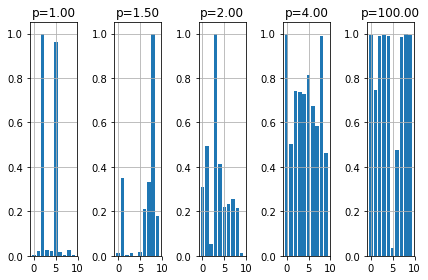

In [148]:
np.random.seed(42)
xs = np.array([1.0, 1.5, 2.0, 4.0, 100.0])
sparsity = np.zeros((xs.size, X.shape[0]))
for i in range(xs.size):
    fun = partial(fun_lp_norm_ocsvm, X=X, p=xs[i], nu=1.0)
    grad = partial(grad_lp_norm_ocsvm, X=X, p=xs[i], nu=1.0)

    xstar = findMinSG(fun, grad, np.random.randn(10+1), 0.01, max_evals=2000, eps=1e-3, step_method=1, verbosity=0)
    wstar = xstar[1:]

    wstar = np.abs(wstar)
    wstar /= np.max(wstar)
    sparsity[i, :] = wstar

    plt.subplot(1, xs.size, i+1)
    plt.bar(np.arange(X.shape[0]), sparsity[i, :])
    plt.title('p={0:1.2f}'.format(xs[i]))
    plt.grid()
    
plt.tight_layout()

### 4. Utilizing Available QP Solver Packages: CVXOPT

There are very good general purpose solver for certain types of optimization problems 
available. Most important are cplex, mosek, and cvxopt where the latter is for free and 
contains interfaces for comercial solvers (cplex and mosek).

Back again at the one-class SVM primal problem:

$\min_{w,\rho,\xi} \frac{1}{2}\|w\|^2 - \rho + \frac{1}{n\nu} \sum_{i=1}^n \xi_i$

subject to the following constraints:

$\xi_i \geq 0\;, \quad \langle w, x_i \rangle \geq \rho - \xi_i \; , \quad \forall \; i$

Use cvxopt's qp method to solve this problem (cvxopt.solvers.qp(P, q, G, h))
Hence, the above problem needs to be re-written as:

$\min_x \frac{1}{2}x^T P x + q^T x$ subject to $Gx \leq h$ and $Ax=b$.


In [18]:
def calculate_primal_qp_solution(X, nu):
    # Solution vector 'x' is a concatenation of w \in R^dims, xi \inR^n, rho \in R
    # and hence has a dimensionality of dims+n+rho.
    
    d = X.shape[0]
    n = X.shape[1]
    
    # 1. xi_i >= 0 -> -xi_i <= 0
    G1 = np.concatenate([np.zeros((n, d)), -np.eye(n), np.zeros((n, 1))], axis=1)
    h1 = np.zeros(n)

    # 2. <w, x_i> >= rho - xi_i   ->  -<w, x_i> + rho - xi_i <= 0
    G2 = np.concatenate([-X.T, -np.eye(n), np.ones((n, 1))], axis=1)
    h2 = np.zeros(n)

    # 3. Final inequality constraints
    G = np.concatenate([G1, G2], axis=0)
    h = np.concatenate([h1, h2])

    # 4. Build squared part of the objective
    P = np.zeros((d+n+1, d+n+1))
    P[np.diag_indices(d)] = 1

    # 5. Build linear part of the objective
    q = np.ones(d+n+1) / (n*nu)
    q[:d] = 0
    q[-1] = -1
    
    # solve qp
    sol = cvx.solvers.qp(cvx.matrix(P), cvx.matrix(q), cvx.matrix(G), cvx.matrix(h))
    return np.array(sol['x'])[:d].ravel(), np.array(sol['x'])[d:d+n].ravel(), np.array(sol['x'])[-1]

In [19]:
wstar, xistar, rhostar = calculate_primal_qp_solution(X, 1.)

print('Optimized solution: ', wstar)
print('Truth: ', np.mean(X, axis=1))
print('Difference: ', np.linalg.norm(wstar - np.mean(X, axis=1)))

     pcost       dcost       gap    pres   dres
 0: -1.0239e-03  1.0003e+00  2e+03  4e+01  1e+03
 1:  9.8794e-01 -2.0372e+01  2e+01  5e-01  1e+01
 2:  8.3192e-01 -5.8026e-01  1e+00  1e-02  3e-01
 3:  7.9525e-02 -1.7408e-02  1e-01  5e-04  1e-02
 4: -4.8269e-03 -6.1600e-03  1e-03  6e-06  1e-04
 5: -6.0039e-03 -6.0172e-03  1e-05  6e-08  1e-06
 6: -6.0157e-03 -6.0158e-03  1e-07  6e-10  1e-08
 7: -6.0158e-03 -6.0158e-03  1e-09  6e-12  1e-10
Optimal solution found.
Optimized solution:  [ 0.01933206  0.07083624  0.00583421 -0.01871922 -0.04927364 -0.0467376
 -0.02815652  0.01921704  0.01834177 -0.01203418]
Truth:  [ 0.01933206  0.07083624  0.00583421 -0.01871922 -0.04927364 -0.0467376
 -0.02815652  0.01921704  0.01834177 -0.01203418]
Difference:  6.152304300864263e-11


As you might notice, coding the derivatives is not trivial and takes the most of the time. There are some methods build-in scipy that help you with that and also optimize using more elaborate techniques such as second-order L-BFGS (a memory-limited newton descent). Here, let's recycle some of our functions...

### 5. Utilizing Available Solver Packages: SciPy's Optimization Suite

Here is a link to the scipy 'minimize' function which implements lots of solvers for smooth (un-)constrained
optimization problems:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

We will recycle our smooth one-class SVM objective function.

In [20]:
# Generate some test data
np.random.seed(42)
X = np.random.randn(10, 100)

fun = partial(fun_smooth_ocsvm, X=X, nu=1.0, delta=0., epsilon=0.5)

res = minimize(fun, 0.0*np.random.randn(10+1), method='L-BFGS-B', options={'gtol': 1e-6, 'disp': True})
xstar = res.x
wstar = xstar[1:]

print(wstar)
print(np.mean(X, axis=1))
print(np.linalg.norm(wstar - np.mean(X, axis=1)))

[-0.10384648  0.02230469  0.0648961   0.10683998 -0.05600427 -0.11530585
  0.02409342 -0.00616031  0.22864798  0.0278537 ]
[-0.10384652  0.02230459  0.06489625  0.10684012 -0.05600447 -0.1153056
  0.02409386 -0.00616057  0.22864907  0.02785382]
1.2743361250048722e-06
